In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from google.colab import drive
from google.colab import files
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [19]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Analyze the distribution of paintings per artist in the train/val dataset

Load the datasets:

In [20]:
root_path = "/content/drive/Shareddrives/[Deep Learning Project]"
dataset_dir = os.path.join(root_path, "Dataset")
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

Print the number of paintings per artist in the "train" dataset:

In [8]:
classes_size=[]
classes_name=[]
for dir in os.listdir(train_dir):
  dir_size=len(os.listdir(train_dir+"/"+dir))
  classes_size.append(dir_size)
  classes_name.append(dir)
  print(dir+": ",dir_size)

Alfred Sisley:  207
Edgar Degas:  561
Paul Klee:  150
Sandro Botticelli:  131
Paul Gauguin:  248
Pablo Picasso:  351
Amedeo Modigliani:  154
Vincent van Gogh:  701
Andy Warhol:  144
Albrecht Dürer:  262
Francisco Goya:  232
Henri Matisse:  148
Rembrandt:  209
Marc Chagall:  191
Rene Magritte:  155
Mikhail Vrubel:  136
Titian:  204
Pierre-Auguste Renoir:  268


Plot the distribution:

<BarContainer object of 18 artists>

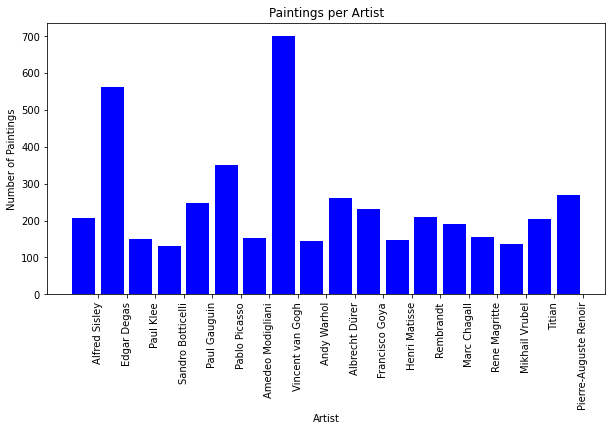

In [9]:
plt.figure(figsize=(10,5))

artists_list= classes_name
N_paintings_list = classes_size

length = len(artists_list)

plt.xticks(np.arange(length) + .5, artists_list, rotation=90)
plt.xlabel("Artist")
plt.ylabel('Number of Paintings')
plt.title('Paintings per Artist')

plt.bar(artists_list, N_paintings_list, color='blue', label='Number of Painting by Artist')

Let's check if the dataset is unbalanced. As a rule of thumb, if the dataset has a difference (majority class - minority class) of greater than 65% to 35% is considered unbalanced.

In [16]:
largest_class_size = max(classes_size)
smallest_class_size = min(classes_size)
difference = largest_class_size - smallest_class_size
perc_difference_with_max = difference/largest_class_size *100
perc_difference_with_min = difference/smallest_class_size *100
print("majority class size: ",largest_class_size, "\nminority class size: ",smallest_class_size, "\n-> difference: ",difference)
print("-> percentage of difference/(largest class size): ",perc_difference_with_max ,"%")

majority class size:  701 
minority class size:  131 
-> difference:  570
-> percentage of difference/(largest class size):  81.31241084165478 %


From the results obtained we can consider our dataset not balanced.

# Create new training directory for Data Augmentation

Let's create a new directory copying the train directory:

In [9]:
augmented_train_dir = "/content/drive/Shareddrives/[Deep Learning Project]/Dataset/augmented_train"

shutil.copytree(train_dir, augmented_train_dir)
# shutil.rmtree(augmented_train_dir)

'/content/drive/Shareddrives/[Deep Learning Project]/Dataset/augmented_train'

Print the number of samples per class in augmented train directory:

In [10]:
def take_classes_size(directory):
  classes_size=[]
  classes_name=[]
  for dir in os.listdir(directory):
    dir_size=len(os.listdir(directory+"/"+dir))
    classes_size.append(dir_size)
    classes_name.append(dir)
    print(dir+": ",dir_size)
  return classes_name,classes_size

In [11]:
classes_name, classes_size = take_classes_size(augmented_train_dir)
print("\nTotal paintings:", sum(classes_size))

Alfred Sisley:  207
Edgar Degas:  561
Paul Klee:  150
Sandro Botticelli:  131
Paul Gauguin:  248
Pablo Picasso:  351
Amedeo Modigliani:  154
Vincent van Gogh:  701
Andy Warhol:  144
Albrecht Dürer:  262
Francisco Goya:  232
Henri Matisse:  148
Rembrandt:  209
Marc Chagall:  191
Rene Magritte:  155
Mikhail Vrubel:  136
Titian:  204
Pierre-Auguste Renoir:  268

Total paintings: 4452


# Data Augmentation for minority classes

In [12]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.1), # Rotates the input images by a random value in the range[–10%, +10%] (fraction of full circle [-36°, 36°])
  layers.RandomZoom(0.2) # Zooms in or out of the image by a random factor in the range [-20%, +20%]
])

Plot an example:

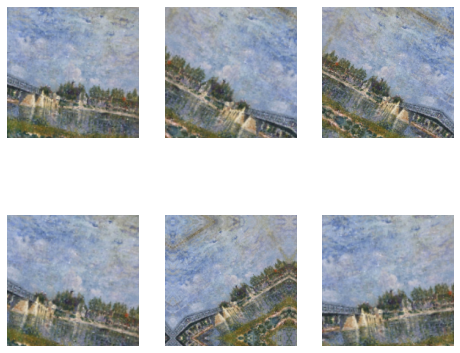

In [13]:
IMAGE_HEIGHT =IMAGE_WIDTH= 180

for artist_name in os.listdir(train_dir):
  for image_name in os.listdir(train_dir+"/"+artist_name):

    img = tf.keras.utils.load_img(train_dir+"/"+artist_name+"/"+image_name, 
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

    img_array = tf.keras.utils.img_to_array(img)
    # plt.imshow(img_array.astype("uint8"))

    plt.figure(figsize=(8, 7))
    for i in range(6):
      augmented_image = data_augmentation(img_array)
      ax = plt.subplot(2, 3, i + 1)
      plt.imshow(augmented_image.numpy().astype("uint8"))
      plt.axis("off")
    break
  break

Let's use Data Augmentation to increase minority classes in order to have at least 450 paintings per artist:

In [14]:
from ast import Break
import matplotlib.image as mpimg

min_number_of_samples=450

for artist_name in os.listdir(augmented_train_dir):

  n_images_added_counter=0
  artist_listdir=os.listdir(augmented_train_dir+"/"+artist_name)

  if(len(artist_listdir)<min_number_of_samples):

    n_samples_to_be_added = min_number_of_samples-len(artist_listdir)

    while ((len(artist_listdir) + n_images_added_counter) < min_number_of_samples):
      
      for image_name in os.listdir(train_dir+"/"+artist_name):
          if(n_images_added_counter >= n_samples_to_be_added):
                break
          
          img = tf.keras.utils.load_img(train_dir+"/"+artist_name+"/"+image_name, 
                                        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
          
          img_array = tf.keras.utils.img_to_array(img)
          augmented_image = data_augmentation(img_array) #create a single augmented image
          tf.keras.utils.save_img(augmented_train_dir+'/'+artist_name+'/'+str(n_images_added_counter)+'_augm.jpg', augmented_image)

          n_images_added_counter+=1

In [15]:
classes_name, classes_size = take_classes_size(augmented_train_dir)

Alfred Sisley:  450
Edgar Degas:  561
Paul Klee:  450
Sandro Botticelli:  450
Paul Gauguin:  450
Pablo Picasso:  450
Amedeo Modigliani:  450
Vincent van Gogh:  701
Andy Warhol:  450
Albrecht Dürer:  450
Francisco Goya:  450
Henri Matisse:  450
Rembrandt:  450
Marc Chagall:  450
Rene Magritte:  450
Mikhail Vrubel:  450
Titian:  450
Pierre-Auguste Renoir:  450


Plot the new class distribution:

<BarContainer object of 18 artists>

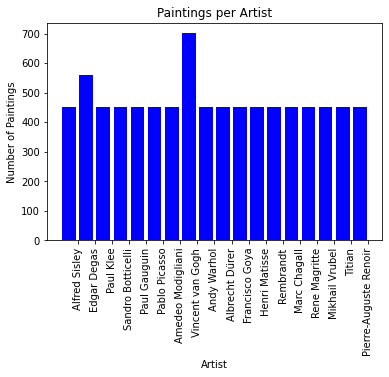

In [16]:
artists_list= classes_name
N_paintings_list = classes_size

length = len(artists_list)

plt.xticks(np.arange(length) + .5, artists_list, rotation=90)
plt.xlabel("Artist")
plt.ylabel('Number of Paintings')
plt.title('Paintings per Artist')

plt.bar(artists_list, N_paintings_list, color='blue', label='Number of Painting by Artist')

# Weight the classes based on the new augmented dataset


In [21]:
# Read the artists.csv file

artists = pd.read_csv('/content/drive/Shareddrives/[Deep Learning Project]/Dataset/artists.csv')

Weight creation:

In [74]:
classes_size=[]
classes_name=[]
classes_weight=[]

for dir in os.listdir(augmented_train_dir):
  dir_size=len(os.listdir(augmented_train_dir+"/"+dir))
  classes_size.append(dir_size)
  classes_name.append(dir)

tot_paintings=sum(classes_size)
number_of_classes=len(classes_size)

for i in range(number_of_classes):
  w=tot_paintings/(number_of_classes*classes_size[i])
  classes_weight.append(w)


# Then we need a dictionary with a number as a key and the weight as value
class_weight = {i : classes_weight[i] for i in range(len(classes_weight))}

weight_dict = {(classes_name[i],classes_size[i]) : classes_weight[i] for i in range(len(classes_weight))}

for n in range(number_of_classes):
  print(classes_name[n]+":")
  print(f'{"number of images-> "}{classes_size[n]}{" , weight-> "}{class_weight[n]:.2f}')

# print(class_weight)
# print(weight_dict)
print("\nTotal number of paintings in augmented training set:",tot_paintings)

Alfred Sisley:
number of images-> 450 , weight-> 1.04
Edgar Degas:
number of images-> 561 , weight-> 0.84
Paul Klee:
number of images-> 450 , weight-> 1.04
Sandro Botticelli:
number of images-> 450 , weight-> 1.04
Paul Gauguin:
number of images-> 450 , weight-> 1.04
Pablo Picasso:
number of images-> 450 , weight-> 1.04
Amedeo Modigliani:
number of images-> 450 , weight-> 1.04
Vincent van Gogh:
number of images-> 701 , weight-> 0.67
Andy Warhol:
number of images-> 450 , weight-> 1.04
Albrecht Dürer:
number of images-> 450 , weight-> 1.04
Francisco Goya:
number of images-> 450 , weight-> 1.04
Henri Matisse:
number of images-> 450 , weight-> 1.04
Rembrandt:
number of images-> 450 , weight-> 1.04
Marc Chagall:
number of images-> 450 , weight-> 1.04
Rene Magritte:
number of images-> 450 , weight-> 1.04
Mikhail Vrubel:
number of images-> 450 , weight-> 1.04
Titian:
number of images-> 450 , weight-> 1.04
Pierre-Auguste Renoir:
number of images-> 450 , weight-> 1.04

Total number of paintings

Creation of the dict of weight and order in alphabetic order:

In [80]:
sorted_weight_dict = dict(sorted(weight_dict.items()))
sorted_n_augm_paintings=[]

for key in sorted_weight_dict:
  print(key[0],'->', sorted_weight_dict[key])
  sorted_n_augm_paintings.append(key[1])

sorted_weights = sorted_weight_dict.values()
# print(sorted_n_augm_paintings)
# print(sorted_weights)

Albrecht Dürer -> 1.0446913580246913
Alfred Sisley -> 1.0446913580246913
Amedeo Modigliani -> 1.0446913580246913
Andy Warhol -> 1.0446913580246913
Edgar Degas -> 0.8379877203406615
Francisco Goya -> 1.0446913580246913
Henri Matisse -> 1.0446913580246913
Marc Chagall -> 1.0446913580246913
Mikhail Vrubel -> 1.0446913580246913
Pablo Picasso -> 1.0446913580246913
Paul Gauguin -> 1.0446913580246913
Paul Klee -> 1.0446913580246913
Pierre-Auguste Renoir -> 1.0446913580246913
Rembrandt -> 1.0446913580246913
Rene Magritte -> 1.0446913580246913
Sandro Botticelli -> 1.0446913580246913
Titian -> 1.0446913580246913
Vincent van Gogh -> 0.670629259787605


Order the artists in alphabetic order and associate to them the weights for the augmented dataset:

In [110]:
artists = artists.sort_values(by=['name']).assign(weight=sorted_weights, augm_train_paintings = sorted_n_augm_paintings)
artists = artists.sort_index()

Change the column name from weight to weight balanced:

In [115]:
if "weight balanced" not in artists:
  artists.rename(columns={"weight":"weight balanced"}, inplace=True)

Print the final artists.csv:

In [116]:
artists

,name,genre,paintings,augm_train_paintings,weight balanced
0,Amedeo Modigliani,Expressionism,193,450,1.044691
1,Rene Magritte,"Surrealism,Impressionism",194,450,1.044691
2,Vincent van Gogh,Post-Impressionism,877,701,0.670629
3,Mikhail Vrubel,Symbolism,171,450,1.044691
4,Pablo Picasso,Cubism,439,450,1.044691
5,Pierre-Auguste Renoir,Impressionism,336,450,1.044691
6,Francisco Goya,Romanticism,291,450,1.044691
7,Albrecht Dürer,Northern Renaissance,328,450,1.044691
8,Alfred Sisley,Impressionism,259,450,1.044691
9,Marc Chagall,Primitivism,239,450,1.044691


Save the artists info into a csv on the shared drive:

In [117]:
artists.to_csv('/content/drive/Shareddrives/[Deep Learning Project]/Dataset/artists.csv', index=False)

Check if it is saved correctly:

In [118]:
# Read the artists.csv file

artists = pd.read_csv('/content/drive/Shareddrives/[Deep Learning Project]/Dataset/artists.csv')
artists

,name,genre,paintings,augm_train_paintings,weight balanced
0,Amedeo Modigliani,Expressionism,193,450,1.044691
1,Rene Magritte,"Surrealism,Impressionism",194,450,1.044691
2,Vincent van Gogh,Post-Impressionism,877,701,0.670629
3,Mikhail Vrubel,Symbolism,171,450,1.044691
4,Pablo Picasso,Cubism,439,450,1.044691
5,Pierre-Auguste Renoir,Impressionism,336,450,1.044691
6,Francisco Goya,Romanticism,291,450,1.044691
7,Albrecht Dürer,Northern Renaissance,328,450,1.044691
8,Alfred Sisley,Impressionism,259,450,1.044691
9,Marc Chagall,Primitivism,239,450,1.044691
